In [1]:
import os
import numpy as np
import torch
from PIL import Image

from torch import nn, optim

import visionutils.transforms as T
from visionutils.engine import train_one_epoch, evaluate
import visionutils.utils

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torchvision.models import resnet18, ResNet18_Weights

import matplotlib.pyplot as plt

from utils.nn import ClusterDataset, get_transform, get_instance_segmentation_model, get_instance_frcnn_model
from utils.evaluate import make_cat, reduce_cat, eval_model

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#This function computes the inverse-variance weighted average of a data vector
def inv_var(data, variances):
    ave = 0
    var = 0
    for i in range(len(data)):
        ave += data[i]/variances[i]**2
        var += 1/variances[i]**2
    return ave/var, np.sqrt(1/var)

#This function evaluates the performance of a model on a single image
def eval_img(img, truth, model, threshold = 0.5):
    xs = []
    ys = []
    errs = []

    # put the model in evaluation mode
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])
    for i in range(len(prediction[0]['boxes'])):
        if prediction[0]['scores'][i]>=threshold:
            xmin, ymin, xmax, ymax = prediction[0]['boxes'][i].cpu().numpy()
            xs.append((xmax+xmin)/2)
            ys.append((ymax+ymin)/2)
            errs.append(prediction[0]['scores'][i].cpu().numpy())
            #print(xs[-1], ys[-1])
    
    print("X loc: ", inv_var(xs, errs))
    print("Y loc: ", inv_var(ys, errs))

# Begin Training

In [3]:
tile_type = "indv"

In [4]:

#root = '/project/r/rbond/jorlo/datasets/ACT_tiles/'
root = "/mnt/welch/USERS/jorlo/ml-clusters/ACT_tiles"
len(list(sorted(os.listdir(os.path.join(root, "{}_masks".format(tile_type))))))

4195

In [5]:
# use our dataset and defined transformations
dataset = ClusterDataset(root, get_transform(train=True),
                        cluster_dir = '{}_freq_stamps'.format(tile_type),
                        mask_dir = '{}_freq_masks'.format(tile_type))
dataset_test = ClusterDataset(root, get_transform(train=False),
                        cluster_dir = '{}_freq_stamps'.format(tile_type), 
                        mask_dir = '{}_freq_masks'.format(tile_type))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

test_num = 20
dataset = torch.utils.data.Subset(dataset, indices[:-test_num])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-test_num:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=True, num_workers=4,
    collate_fn=visionutils.utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=visionutils.utils.collate_fn)

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

backbone = 'mobilenet'
backbone_path = "/mnt/welch/USERS/jorlo/ml-clusters/models/torch-act/"
# get the model using our helper function
model = get_instance_frcnn_model(num_classes, backbone_path = backbone_path + "act-{}.pth".format(backbone), backbone_type = backbone)
#model = get_instance_frcnn_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

/home/jorlo/dev/ml-clusters/utils/nn.py:157: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  backbone_model.load_state_dict(torch.load(backbone_path))


In [7]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 10

model_path = "/mnt/welch/USERS/jorlo/ml-clusters/models/torch-act/act-{}-frcnn-{}-tiles.pth".format(backbone, tile_type)
load_exiting_weights = True
if load_exiting_weights and os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)
    torch.save(model.state_dict(), model_path)


/tmp/ipykernel_823054/3301047284.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Epoch: [0]  [   0/1033]  eta: 0:12:07  lr: 0.000010  loss: 0.0223 (0.0223)  loss_classifier: 0.0100 (0.0100)  loss_box_reg: 0.0110 (0.0110)  loss_objectness: 0.0011 (0.0011)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.7045  data: 0.1007  max mem: 10276
Epoch: [0]  [  10/1033]  eta: 0:05:33  lr: 0.000060  loss: 0.0311 (0.0317)  loss_classifier: 0.0126 (0.0129)  loss_box_reg: 0.0163 (0.0155)  loss_objectness: 0.0028 (0.0029)  loss_rpn_box_reg: 0.0004 (0.0004)  time: 0.3263  data: 0.0190  max mem: 10593
Epoch: [0]  [  20/1033]  eta: 0:05:11  lr: 0.000110  loss: 0.0296 (0.0304)  loss_classifier: 0.0124 (0.0126)  loss_box_reg: 0.0136 (0.0142)  loss_objectness: 0.0028 (0.0033)  loss_rpn_box_reg: 0.0003 (0.0004)  time: 0.2882  data: 0.0101  max mem: 10593
Epoch: [0]  [  30/1033]  eta: 0:05:02  lr: 0.000160  loss: 0.0296 (0.0308)  loss_classifier: 0.0124 (0.0130)  loss_box_reg: 0.0130 (0.0140)  loss_objectness: 0.0029 (0.0035)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2882  data: 0.0094  max

### Reload model

In [8]:
#model.load_state_dict(torch.load("/project/r/rbond/jorlo/ml-clusters/models/torch-act/act-mobilenet-frcnn.pth"))
#model.load_state_dict(torch.load(model_path + "act-{}-frcnn-indv.pth".format(backbone)))
#model_path = "/mnt/welch/USERS/jorlo/ml-clusters/models/torch-act/"

#model.load_state_dict(torch.load(model_path+"act-{}-frcnn-{}-tiles.pth".format(backbone, tile_type)))
#model.load_state_dict(torch.load("/mnt/welch/USERS/jorlo/ml-clusters/models/mist-torch-act/act-resnet-frcnn-tiles.pth"))

In [9]:
tile_type = "indv"
dataset = ClusterDataset(root, get_transform(train=True),
                        cluster_dir = '{}_freq_stamps'.format(tile_type),
                        mask_dir = '{}_freq_masks'.format(tile_type))
dataset_test = ClusterDataset(root, get_transform(train=False),
                        cluster_dir = '{}_freq_stamps'.format(tile_type), 
                        mask_dir = '{}_freq_masks'.format(tile_type))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

test_num = 200
dataset = torch.utils.data.Subset(dataset, indices[:-test_num])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-test_num:])

In [10]:
for j in range(10):

    img, truth = dataset_test[j]
    # put the model in evaluation mode
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])
    print(truth)
    print(prediction)
    print('\n')

{'boxes': tensor([[33., 59., 41., 67.],
        [52., 53., 60., 61.]]), 'labels': tensor([1, 1]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8), 'image_id': tensor([1334]), 'area': tensor([64., 64.]), 'iscrowd': tensor([0, 0])}
[{'boxes': tensor([[33.3875, 58.8419, 41.4157, 66.9102],
        [53.2355, 53.6062, 61.1662, 61.7274],
        [62.6384, 29.2358, 70.4715, 37.1842],
        [68.2823,  0.0000, 76.4336,  4.9342],
        [68.5176,  0.0000, 75.5938,  2.8067]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9704, 

In [12]:
img_path = "/mnt/welch/USERS/jorlo/ml-clusters/ACT_tiles/indv_freq_stamps/{:04}.fits"

cents = make_cat(model, dataset_test, img_path, device)

In [13]:
cat = reduce_cat(cents)

In [14]:
cat

[array([27.94262241,  1.49719108]),
 array([28.00350698,  1.55788987]),
 array([25.91532472, -3.42926668]),
 array([ 18.09604664, -16.70834306]),
 array([ 18.013331  , -16.79130561]),
 array([ 18.33165741, -16.47240308]),
 array([ 18.24482307, -16.55952174]),
 array([ 4.67945792, 16.06727873]),
 array([ 4.84641666, 16.23378359]),
 array([ 4.74649804, 16.134493  ]),
 array([102.77528419, -40.58710028]),
 array([ 40.47828217, -40.93381163]),
 array([317.25357825,  12.31596171]),
 array([317.21035894,  12.27256444]),
 array([317.3386692,  12.3955513]),
 array([  3.18069884, -37.7070027 ]),
 array([  3.36973839, -37.51628119]),
 array([  3.47104053, -37.42404048]),
 array([219.98972111,  11.02026386]),
 array([219.95083577,  10.97930508]),
 array([ 77.21852074, -27.15261707]),
 array([33.40224075,  6.46470661]),
 array([331.88608475, -57.49307442]),
 array([202.04973005,  -0.57095153]),
 array([338.78676332, -44.19274654]),
 array([338.56147226, -44.41765734]),
 array([338.90612024, -44.07

In [15]:
cents

[array([[27.94262241,  1.49719108],
        [28.00350698,  1.55788987],
        [27.94114246,  1.49439888]]),
 array([[25.91532472, -3.42926668]]),
 array([[ 18.09604664, -16.70834306],
        [ 18.013331  , -16.79130561],
        [ 18.33165741, -16.47240308],
        [ 18.24482307, -16.55952174]]),
 array([[ 4.67945792, 16.06727873],
        [ 4.84641666, 16.23378359],
        [ 4.74649804, 16.134493  ]]),
 array([[102.77528419, -40.58710028]]),
 array([[ 40.47828217, -40.93381163]]),
 array([[317.25357825,  12.31596171],
        [317.21035894,  12.27256444],
        [317.3386692 ,  12.3955513 ]]),
 array([[  3.18069884, -37.7070027 ],
        [  3.36973839, -37.51628119],
        [  3.47104053, -37.42404048]]),
 array([[219.98972111,  11.02026386],
        [219.95083577,  10.97930508]]),
 array([[ 77.21852074, -27.15261707]]),
 array([[33.40224075,  6.46470661]]),
 array([[331.88608475, -57.49307442]]),
 array([[202.04973005,  -0.57095153]]),
 array([[338.78676332, -44.19274654],
  

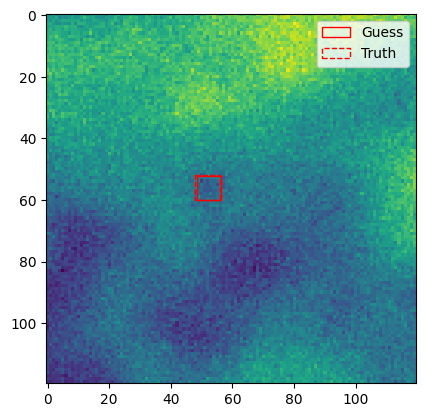

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(img[0,...])

colors = ["red", "black", "purple", "green", "yellow"]

for i in range(len(prediction[0]['boxes'])):
    if prediction[0]['scores'][i]>=0.5:
        xmin, ymin, xmax, ymax = prediction[0]['boxes'][i].cpu().numpy()
        rectangle = plt.Rectangle((xmin,ymin), xmax-xmin,ymax-ymin, fc='none',ec=colors[i], label = 'Guess')
        ax.add_patch(rectangle)
        
for i in range(len(truth['boxes'])):
    xmin, ymin, xmax, ymax = truth['boxes'][i].cpu().numpy()
    rectangle = plt.Rectangle((xmin,ymin), xmax-xmin,ymax-ymin, fc='none',ec=colors[i], linestyle = '--', label = 'Truth')
    ax.add_patch(rectangle)

plt.legend()
plt.savefig('./figs/region_prop_{}.png'.format(j))
plt.savefig('./figs/region_prop_{}.pdf'.format(j))

plt.show()
plt.close()

In [17]:
len(prediction[0]['boxes'])

1

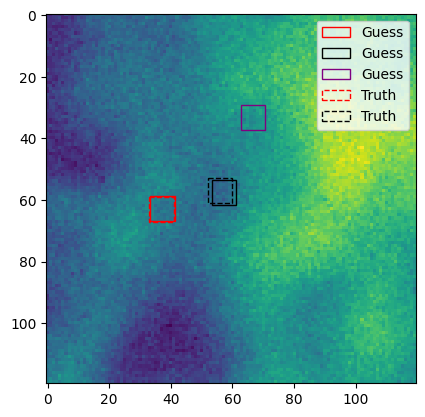

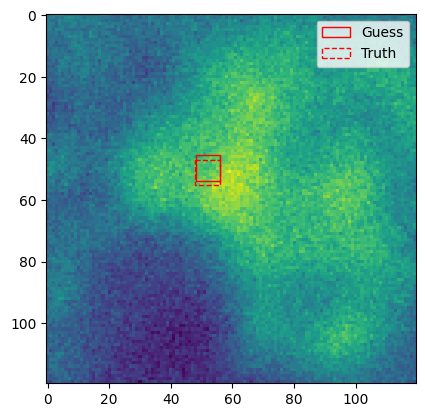

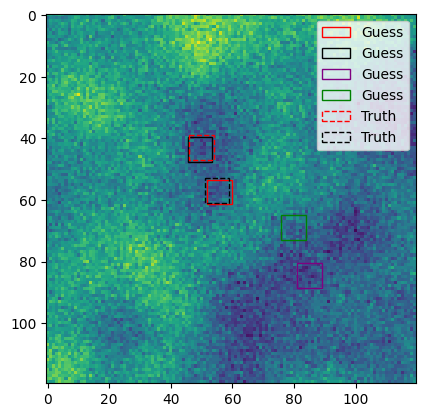

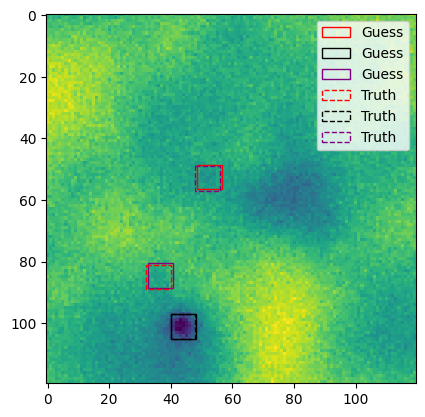

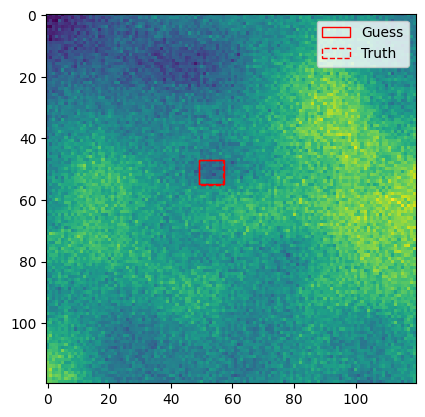

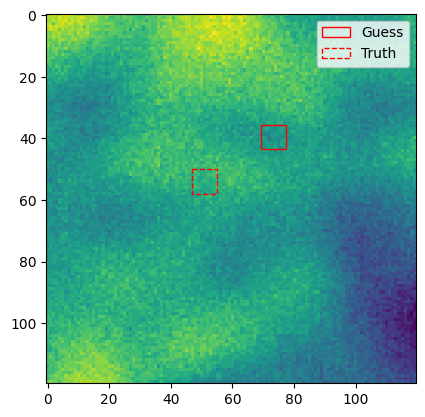

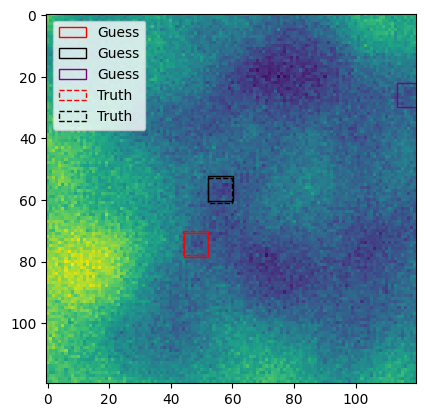

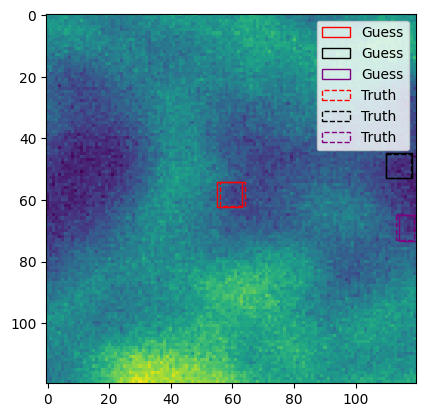

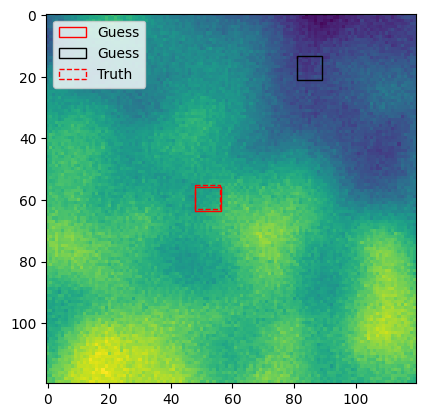

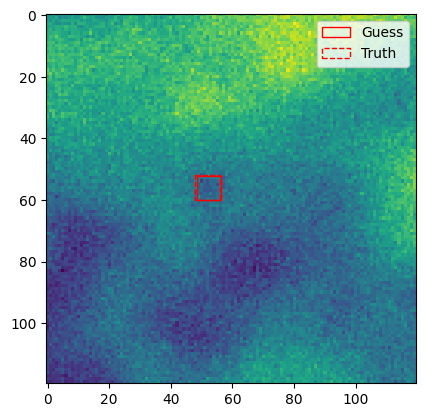

In [18]:
for j in range(10):
    img, truth = dataset_test[j]
    # put the model in evaluation mode
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.imshow(img[0,...])

    colors = ["red", "black", "purple", "green", "yellow"]

    for i in range(len(prediction[0]['boxes'])):
        if prediction[0]['scores'][i]>=0.5:
            xmin, ymin, xmax, ymax = prediction[0]['boxes'][i].cpu().numpy()
            rectangle = plt.Rectangle((xmin,ymin), xmax-xmin,ymax-ymin, fc='none',ec=colors[i], label = 'Guess')
            ax.add_patch(rectangle)

    for i in range(len(truth['boxes'])):
        xmin, ymin, xmax, ymax = truth['boxes'][i].cpu().numpy()
        rectangle = plt.Rectangle((xmin,ymin), xmax-xmin,ymax-ymin, fc='none',ec=colors[i], linestyle = '--', label = 'Truth')
        ax.add_patch(rectangle)

    plt.legend()
    plt.savefig('./figs/region_prop_{}.png'.format(j))
    plt.savefig('./figs/region_prop_{}.pdf'.format(j))

    plt.show()
    plt.close()

# Garbage

In [ ]:
for j in range(455):
    mask_list = list(sorted(os.listdir(os.path.join('/project/r/rbond/jorlo/datasets/ACT_tiles/', "masks"))))
    mask_path = os.path.join('/project/r/rbond/jorlo/datasets/ACT_tiles/', "masks", mask_list[j])
    with np.load(mask_path) as data:
        mask = data['arr_0']
    # convert the PIL Image into a numpy array
    mask = np.array(mask)
    # instances are encoded as different colors
    obj_ids = np.unique(mask)
    # first id is the background, so remove it
    obj_ids = obj_ids[1:]
    # split the color-encoded mask into a set
    # of binary masks
    masks = mask == obj_ids[:, None, None]
    # get bounding box coordinates for each mask
    num_objs = len(obj_ids)
    boxes = []
    for i in range(num_objs):
        pos = np.where(masks[i])
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        boxes.append([xmin, ymin, xmax, ymax])
        if xmin==xmax and ymin == ymax:
            print(mask_list[j])
        
        

    # convert everything into a torch.Tensor
    boxes = torch.as_tensor(boxes, dtype=torch.float32)

In [ ]:
path = root + "/"
tile = '1_1_0'


with np.load(path+'small_freq_tiles/'+tile+'.npz') as data:
        img = data['arr_0']
with np.load(path+'small_masks/'+tile+'_mask.npz') as data:
        mask = data['arr_0']
img = np.array(img)
mask = np.array(mask)
# instances are encoded as different colors
obj_ids = np.unique(mask)
# first id is the background, so remove it
obj_ids = obj_ids[1:]
# split the color-encoded mask into a set
# of binary masks
masks = mask == obj_ids[:, None, None]
# get bounding box coordinates for each mask
num_objs = len(obj_ids)
boxes = []
for i in range(num_objs):
    pos = np.where(masks[i])
    xmin = np.min(pos[1])
    xmax = np.max(pos[1])
    ymin = np.min(pos[0])
    ymax = np.max(pos[0])
    boxes.append([xmin, ymin, xmax, ymax])

img = np.ascontiguousarray(img.transpose(2,0,1))
model.eval()

img = torch.as_tensor(img, dtype=torch.float32)
with torch.no_grad():
    prediction = model([img.to(device)])